### 統計學習與深度學習
#### 學號：R09725060 姓名：黃瀚陞

### Homework 4

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Multilayer Perceptrons for Regression
本次作業的主角是 Multilayer perceptrons (MLP)。我們將以MLP建構迴歸模型，探討各項相關議題。


#### Dataset: Million Songs Dataset
本次作業將使用"Million Songs Dataset"作為訓練與測試資料。請使用`pickle.load()`載入*msd_full.pickle*。這個資料集已經切割好了訓練與測試資料，並存放在一個Dictionary的結構。這個Dictionary有四個元素，x_train, y_train, x_test, y_test，分別對應到訓練特徵、訓練標記(Label)、測試特徵、測試標記。 標記變數 (label variable; i.e., $y$) 是歌曲發行年度。特徵為歌曲的聲音特性。迴歸任務為預測歌曲年分。

#### Prediction Performance and Loss Function
模型訓練應主要使用Sum of Squared Error (SSE)建構Loss Function，另外我們也會練習使用其他種類的Loss Function。為了讓圖表易於理解，不論Loss Function為何，報告預測能力應使用Root Mean Squared Error (RMSE)。使用SSE或RMSE建構Loss Function在本質上沒有差別。但SSE計算成本稍低，而RMSE較有直觀意義。


#### Subtraining, Validation, and Test Datasets
*msd_full.pickle* 檔案中的訓練資料已經隨機排序過。你應該使用訓練資料最後10%的資料做為Validation Set。其餘的前90%做為Subtraining Set。使用Subtraining Set來訓練資料，並以Validation Set作為參數調教與Early Stopping的依據。Test RMSE應使用測試資料計算得之。

所有特徵應該標準化(均數為零，變異數為一)。標準化應該以訓練資料(注意不是Test Set or Subtraining Set)的統計量為之。標記變數(i.e., $y$)應將均數平移至0 (依照訓練資料的統計量)。標記變數的變異數不要調整。


#### Minibatch, Epoch, and Early Stopping
如果沒有特別說明，模型訓練時應以大小為1,000個資料點的Minibatch為之。模型使用一個Minibatch的資料更新參數之後稱為經歷了一個Batch。當所有Subtraining資料已經用來更新過模型參數，稱為經過了一個Epoch。

模型訓練應使用Early Stopping決定最佳的模型。模型訓練時每100個Batch計算一次Training and Validation RMSE。如果Validation為歷史最低，則記下當下的模型參數與當時已進行的Batch數量，稱為best_step_count。如由best_step_count起算已經經過了5,000個Batch而沒有更好的Validation RMSE，則停止模型訓練，並以best_step_count時的模型參數做為最後的模型訓練結果。如果模型訓練最多執行100個epoch。如果模型已經執行了100個epoch而沒有Early Stop，則應使用歷史最佳的Validation RMSE所對應到的模型參數計算Test RMSE。


#### Implementation Restriction
使用Pytorch建構MLP模型。Ordinary Least Square (OLS)模型訓練沒有限制使用何種套件。

#### 資料載入
使用下面的程式碼載入資料:

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import pandas as pd

import torch
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, Xnp, Ynp):
        'Initialization, passing Xnp and Ynp'
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
    def __len__(self):
        'Denotes the total number of samples'
        return self.nobs
    def __getitem__(self, index):
        'Generates one sample of data'        
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

In [2]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### 回答下面問題

#### Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。


In [3]:
linear_reg=LinearRegression().fit(X_train,Y_train)
y_pred=linear_reg.predict(X_test)
mse=mean_squared_error(Y_test,y_pred)
rmse = math.sqrt(mse)
print("RMSE:",rmse)
print("Parameters:",linear_reg.coef_[:5])

RMSE: 9.510160684544399
Parameters: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


Q1 解釋：  
使用sklearn的Linear Regression來建模並預測，得RMSE約為9.51，前五項特徵的參數如上輸出(Parameters)。

#### Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [4]:
subtrainset=Dataset(X_subtrain,Y_subtrain)    
validset=Dataset(X_valid,Y_valid)
testset=Dataset(X_test,Y_test)
# print("Get SubTrain length:", len(subtrainset))

In [5]:
subtrainloader = data.DataLoader(subtrainset,batch_size=1000, shuffle=True,num_workers=0)
validloader = data.DataLoader(validset, batch_size=1000, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=1000, shuffle=True, num_workers=0)

In [6]:
X_batch,y_batch=next(iter(subtrainloader))
print("X_batch size:", X_batch.size())
print("y_batch size:", y_batch.size())

X_batch size: torch.Size([1000, 90])
y_batch size: torch.Size([1000])


In [7]:
# get number of input features
D_in=subtrainset.Xnp.shape[1]
H=45
# Regressionproblem
D_out = 1
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = "cuda"   
else:
    device = "cpu"
print("Running on device: ", device)
net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
)
# convert everything to float precision. 
net = net.float()
# move the model to device (i.e., cpu or gpu)
net = net.to(device)

Running on device:  cpu


In [8]:
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(),lr = 0.00001,momentum = 0,weight_decay = 0)
# Binary Cross Entropy Loss
loss_fn = torch.nn.MSELoss() # MSE would be used to calculate SSE and RMSE

In [9]:
def calculate_ValidRMSE(net):
    loss_fn = torch.nn.MSELoss()
    valid_accumulated_SSE = 0
    valid_accumulated_N = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validloader):            
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = net(inputs) 
            cn_loss = loss_fn(outputs, targets) * len(inputs) # SSE = MSE * N
            valid_accumulated_N += len(inputs)
            valid_accumulated_SSE += cn_loss
    rmse = math.sqrt(valid_accumulated_SSE / valid_accumulated_N)
    return rmse

In [10]:
nepoch = 100 
step_count = 0 # batch number
log_interval = 100
subtrain_accumulated_SSE = 0
subtrain_accumulated_N = 0

validation_minloss = 999999
best_net = copy.deepcopy(net)
best_step_count = 0
earlystop_waiting = 0

batch_list=[]
subtrain_rmse_list=[]
valid_rmse_list=[]

for epoch_id in range(0, nepoch):
    early_stop=False
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))
        step_count += 1
        net.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = loss_fn(outputs, targets) * len(inputs)
        
        subtrain_accumulated_SSE += loss.item()
        subtrain_accumulated_N += len(inputs)
        
        loss.backward()
        optimizer.step()
        earlystop_waiting+=1
        if step_count % log_interval == 0:
            subtrain_rmse = math.sqrt(subtrain_accumulated_SSE / subtrain_accumulated_N)
            batch_list.append(step_count)
            subtrain_rmse_list.append(subtrain_rmse)
            subtrain_accumulated_SSE = 0
            subtrain_accumulated_N = 0
            valid_rmse = calculate_ValidRMSE(net)
            valid_rmse_list.append(valid_rmse)
            print("Epoch %d Step %d Subtrain_RMSE = %.3f Validation_RMSE = %.3f" % (epoch_id, step_count, subtrain_rmse, valid_rmse))
            if(valid_rmse<validation_minloss):
                validation_minloss=valid_rmse
                best_net=copy.deepcopy(net)
                best_step_count=step_count
                earlystop_waiting=0
        if earlystop_waiting>5000:
            early_stop=True
            break;
    if(early_stop):
        print("Best Step:", best_step_count)
        print("Early stop at:", step_count)
        break;

Epoch 0 Step 100 Subtrain_RMSE = 10.858 Validation_RMSE = 10.889
Epoch 0 Step 200 Subtrain_RMSE = 9.799 Validation_RMSE = 9.124
Epoch 0 Step 300 Subtrain_RMSE = 9.125 Validation_RMSE = 8.896
Epoch 0 Step 400 Subtrain_RMSE = 9.033 Validation_RMSE = 8.842
Epoch 1 Step 500 Subtrain_RMSE = 8.914 Validation_RMSE = 8.930
Epoch 1 Step 600 Subtrain_RMSE = 8.868 Validation_RMSE = 8.842
Epoch 1 Step 700 Subtrain_RMSE = 8.815 Validation_RMSE = 8.735
Epoch 1 Step 800 Subtrain_RMSE = 8.870 Validation_RMSE = 8.749
Epoch 2 Step 900 Subtrain_RMSE = 8.808 Validation_RMSE = 8.750
Epoch 2 Step 1000 Subtrain_RMSE = 8.779 Validation_RMSE = 8.932
Epoch 2 Step 1100 Subtrain_RMSE = 8.746 Validation_RMSE = 8.671
Epoch 2 Step 1200 Subtrain_RMSE = 8.751 Validation_RMSE = 8.701
Epoch 3 Step 1300 Subtrain_RMSE = 8.750 Validation_RMSE = 8.700
Epoch 3 Step 1400 Subtrain_RMSE = 8.695 Validation_RMSE = 8.639
Epoch 3 Step 1500 Subtrain_RMSE = 8.669 Validation_RMSE = 8.659
Epoch 3 Step 1600 Subtrain_RMSE = 8.755 Validat

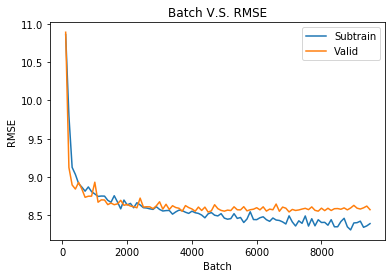

In [11]:
# Q2 Line Chart
plt.plot(batch_list,subtrain_rmse_list,label='Subtrain')
plt.plot(batch_list,valid_rmse_list,label='Valid')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('Batch V.S. RMSE')
plt.legend()
plt.show()

In [12]:
test_accumulated_SSE = 0
test_accumulated_N = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):            
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape((-1, 1))
        outputs = best_net(inputs)        
        cn_loss = loss_fn(outputs, targets) * len(inputs)
        test_accumulated_N += len(inputs)
        test_accumulated_SSE += cn_loss

rmse = math.sqrt(test_accumulated_SSE / test_accumulated_N)
print("TESTING RMSE:", rmse)

TESTING RMSE: 8.851566378667508


Q2解釋：  
從上方的折線圖可看出，一開始不論是subtrain的RMSE還是validation的RMSE都減少得很快，但大概從第2000個batch開始時，減少的速度就開始放緩。  
到了後期（約從第4000個batch之後），subtrain的RMSE有繼續下降，但validation的RMSE卻沒有改善，且兩者的差距也有擴大，可以看到有一點overfitting的情況發生。
最後在Test RMSE的表現上，約為8.85，比Q1中OLS模型的表現還要來得好。

#### Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

In [13]:
def training(net,showsuboutcome):
    nepoch = 100 
    step_count = 0 # batch number
    log_interval = 100
    subtrain_accumulated_SSE = 0
    subtrain_accumulated_N = 0

    validation_minloss = 999999
    best_net = copy.deepcopy(net)
    best_step_count = 0
    earlystop_waiting = 0
    
    for epoch_id in range(0, nepoch):
        early_stop=False
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))
            step_count += 1
            net.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)        
            loss = loss_fn(outputs, targets) * len(inputs)

            subtrain_accumulated_SSE += loss
            subtrain_accumulated_N += len(inputs)

            loss.backward()
            optimizer.step()
            earlystop_waiting+=1
            if step_count % log_interval == 0:
                subtrain_rmse = math.sqrt(subtrain_accumulated_SSE / subtrain_accumulated_N)
                subtrain_accumulated_SSE = 0
                subtrain_accumulated_N = 0
                valid_rmse = calculate_ValidRMSE(net)
                if showsuboutcome:
                    print("Epoch %d Step %d Subtrain_RMSE = %.3f Validation_RMSE = %.3f" % (epoch_id, step_count, subtrain_rmse, valid_rmse))
                if(valid_rmse<validation_minloss):
                    validation_minloss=valid_rmse
                    best_net=copy.deepcopy(net)
                    best_step_count=step_count
                    earlystop_waiting=0
            if earlystop_waiting>5000:
                early_stop=True
                break;
        if(early_stop):
            print("EARLY STOP AT:", step_count)
            break;
    return best_net

In [14]:
def testing(best_net):
    test_accumulated_SSE = 0
    test_accumulated_N = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):            
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = best_net(inputs)        
            cn_loss = loss_fn(outputs, targets) * len(inputs)
            test_accumulated_N += len(inputs)
            test_accumulated_SSE += cn_loss

    rmse = math.sqrt(test_accumulated_SSE / test_accumulated_N)
    print("TESTING RMSE:", rmse)
    return rmse

In [15]:
def createNet(H):
    # get number of input features
    D_in=subtrainset.Xnp.shape[1]
    # Regressionproblem
    D_out = 1
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        device = "cuda"   
    else:
        device = "cpu"
    print("Running on device: ", device)
    net = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),  
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out)
    )
    # convert everything to float precision. 
    net = net.float()
    # move the model to device (i.e., cpu or gpu)
    net = net.to(device)
    return net

In [16]:
net=createNet(90)

# define the optimizer
optimizer = torch.optim.SGD(net.parameters(),lr = 0.00001,momentum = 0,weight_decay = 0)
# Binary Cross Entropy Loss
loss_fn = torch.nn.MSELoss()

best_net=training(net,False)
testing_rmse=testing(best_net)
print("Testing RMSE For H=90:",testing_rmse)

Running on device:  cpu
EARLY STOP AT: 10801
TESTING RMSE: 8.880208810636596
Testing RMSE For H=90: 8.880208810636596


In [17]:
net=createNet(180)

# define the optimizer
optimizer = torch.optim.SGD(net.parameters(),lr = 0.00001,momentum = 0,weight_decay = 0)
# Binary Cross Entropy Loss
loss_fn = torch.nn.MSELoss()

best_net=training(net,False)
testing_rmse=testing(best_net)
print("Testing RMSE For H=180:",testing_rmse)

Running on device:  cpu
EARLY STOP AT: 10001
TESTING RMSE: 8.85771796121714
Testing RMSE For H=180: 8.85771796121714


Q3解釋：  
H=90時的Test RMSE為8.88左右，而H=180的Test RMSE則為8.86。在這題的例子當中，可以發現提高Hidden Nodes的數量至90與180並不會對於Test RMSE有顯著的提升，由此可以推知，這題的情境並不適合太複雜的網路。在選擇上，可以選擇H=45即可。

#### Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

In [18]:
Outcome_list=[]
H_list=[45, 90, 180]
WeightDecay_list=[0.1, 0.2, 0.4]

for i in range(len(H_list)):
    for j in range(len(WeightDecay_list)):
        net=createNet(H_list[i])
        
        # define the optimizer
        optimizer = torch.optim.SGD(net.parameters(),lr = 0.00001, momentum = 0, weight_decay = WeightDecay_list[j])
        # Binary Cross Entropy Loss
        loss_fn = torch.nn.MSELoss() 

        best_net=training(net,False)
        testing_rmse=testing(best_net)
        temp_outcome=[H_list[i],WeightDecay_list[j],testing_rmse]
        print(temp_outcome)
        Outcome_list.append(temp_outcome)

Running on device:  cpu
EARLY STOP AT: 12001
TESTING RMSE: 8.842680633917356
[45, 0.1, 8.842680633917356]
Running on device:  cpu
EARLY STOP AT: 12101
TESTING RMSE: 8.835577002067984
[45, 0.2, 8.835577002067984]
Running on device:  cpu
EARLY STOP AT: 12001
TESTING RMSE: 8.789432283887672
[45, 0.4, 8.789432283887672]
Running on device:  cpu
EARLY STOP AT: 9601
TESTING RMSE: 8.836640320744255
[90, 0.1, 8.836640320744255]
Running on device:  cpu
EARLY STOP AT: 10001
TESTING RMSE: 8.829555591360075
[90, 0.2, 8.829555591360075]
Running on device:  cpu
EARLY STOP AT: 11101
TESTING RMSE: 8.896567773689776
[90, 0.4, 8.896567773689776]
Running on device:  cpu
EARLY STOP AT: 9601
TESTING RMSE: 8.856588689106422
[180, 0.1, 8.856588689106422]
Running on device:  cpu
EARLY STOP AT: 8901
TESTING RMSE: 8.847400572326713
[180, 0.2, 8.847400572326713]
Running on device:  cpu
EARLY STOP AT: 8301
TESTING RMSE: 8.808302725236802
[180, 0.4, 8.808302725236802]


In [19]:
# print(Outcome_list)
df=pd.DataFrame(Outcome_list,columns = ['H','Weight Decay','RMSE',])
df

,H,Weight Decay,RMSE
0,45,0.1,8.842681
1,45,0.2,8.835577
2,45,0.4,8.789432
3,90,0.1,8.836640
4,90,0.2,8.829556
5,90,0.4,8.896568
6,180,0.1,8.856589
7,180,0.2,8.847401
8,180,0.4,8.808303


Q4解釋：  
各H和Weight Decay的對應RMSE如上表格所述，表現最佳的是在H=45且Weight Decay=0.4的情況。  
若是將H=45所對應的三個Weight Decay組合的RMSE取平均，約為(8.842681+8.835577+8.789432)/3=8.82，H=90的RMSE平均則約為8.85，H=180的RMSE平均約為8.84，由此結果可推知，H選擇為45可能會有較好的表現。

#### Q5 MLP with Dropout (15%)
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [20]:
def CreateNetwithDropout(H):
    # get number of input features
    D_in=subtrainset.Xnp.shape[1]
    # Regressionproblem
    D_out = 1
    dropout = 0.5
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        device = "cuda"   
    else:
        device = "cpu"
    print("Running on device: ", device)
    net = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),  
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(H, D_out)
    )
    # convert everything to float precision. 
    net = net.float()
    # move the model to device (i.e., cpu or gpu)
    net = net.to(device)
    
    return net

In [21]:
net=CreateNetwithDropout(90)

# define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
# Binary Cross Entropy Loss
loss_fn = torch.nn.MSELoss()

nepoch = 100 
step_count = 0 # batch number
log_interval = 100
subtrain_accumulated_SSE = 0
subtrain_accumulated_N = 0

validation_minloss = 999999
best_net = copy.deepcopy(net)
best_step_count = 0
earlystop_waiting = 0

batch_list=[]
subtrain_rmse_list=[]
valid_rmse_list=[]

for epoch_id in range(0, nepoch):
    early_stop=False
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))
        step_count += 1
        net.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = loss_fn(outputs, targets) * len(inputs)
        
        subtrain_accumulated_SSE += loss
        subtrain_accumulated_N += len(inputs)
        
        loss.backward()
        optimizer.step()
        earlystop_waiting+=1
        if step_count % log_interval == 0:
            subtrain_rmse = math.sqrt(subtrain_accumulated_SSE / subtrain_accumulated_N)
            batch_list.append(step_count)
            subtrain_rmse_list.append(subtrain_rmse)
            subtrain_accumulated_SSE = 0
            subtrain_accumulated_N = 0
            valid_rmse = calculate_ValidRMSE(net)
            valid_rmse_list.append(valid_rmse)
            print("Epoch %d Step %d Subtrain_RMSE = %.3f Validation_RMSE = %.3f" % (epoch_id, step_count, subtrain_rmse, valid_rmse))
            if(valid_rmse<validation_minloss):
                validation_minloss=valid_rmse
                best_net=copy.deepcopy(net)
                best_step_count=step_count
                earlystop_waiting=0
        if earlystop_waiting>5000:
            early_stop=True
            break;
    if(early_stop):
        print("Best Step:", best_step_count)
        print("Early stop at:", step_count)
        break;

Running on device:  cpu
Epoch 0 Step 100 Subtrain_RMSE = 10.597 Validation_RMSE = 9.779
Epoch 0 Step 200 Subtrain_RMSE = 9.583 Validation_RMSE = 9.405
Epoch 0 Step 300 Subtrain_RMSE = 9.379 Validation_RMSE = 9.254
Epoch 0 Step 400 Subtrain_RMSE = 9.312 Validation_RMSE = 9.171
Epoch 1 Step 500 Subtrain_RMSE = 9.217 Validation_RMSE = 9.138
Epoch 1 Step 600 Subtrain_RMSE = 9.094 Validation_RMSE = 9.105
Epoch 1 Step 700 Subtrain_RMSE = 9.215 Validation_RMSE = 9.065
Epoch 1 Step 800 Subtrain_RMSE = 9.145 Validation_RMSE = 9.064
Epoch 2 Step 900 Subtrain_RMSE = 9.145 Validation_RMSE = 9.041
Epoch 2 Step 1000 Subtrain_RMSE = 9.031 Validation_RMSE = 9.023
Epoch 2 Step 1100 Subtrain_RMSE = 9.104 Validation_RMSE = 9.013
Epoch 2 Step 1200 Subtrain_RMSE = 9.076 Validation_RMSE = 8.990
Epoch 3 Step 1300 Subtrain_RMSE = 9.006 Validation_RMSE = 8.988
Epoch 3 Step 1400 Subtrain_RMSE = 9.051 Validation_RMSE = 8.991
Epoch 3 Step 1500 Subtrain_RMSE = 9.009 Validation_RMSE = 8.962
Epoch 3 Step 1600 Subtra

Epoch 30 Step 12800 Subtrain_RMSE = 8.809 Validation_RMSE = 8.846
Epoch 30 Step 12900 Subtrain_RMSE = 8.875 Validation_RMSE = 8.827
Epoch 31 Step 13000 Subtrain_RMSE = 8.783 Validation_RMSE = 8.846
Epoch 31 Step 13100 Subtrain_RMSE = 8.781 Validation_RMSE = 8.824
Epoch 31 Step 13200 Subtrain_RMSE = 8.900 Validation_RMSE = 8.861
Epoch 31 Step 13300 Subtrain_RMSE = 8.831 Validation_RMSE = 8.844
Epoch 32 Step 13400 Subtrain_RMSE = 8.759 Validation_RMSE = 8.839
Epoch 32 Step 13500 Subtrain_RMSE = 8.834 Validation_RMSE = 8.856
Epoch 32 Step 13600 Subtrain_RMSE = 8.766 Validation_RMSE = 8.839
Epoch 32 Step 13700 Subtrain_RMSE = 8.828 Validation_RMSE = 8.851
Epoch 33 Step 13800 Subtrain_RMSE = 8.838 Validation_RMSE = 8.829
Epoch 33 Step 13900 Subtrain_RMSE = 8.818 Validation_RMSE = 8.878
Epoch 33 Step 14000 Subtrain_RMSE = 8.879 Validation_RMSE = 8.832
Epoch 33 Step 14100 Subtrain_RMSE = 8.778 Validation_RMSE = 8.841
Epoch 33 Step 14200 Subtrain_RMSE = 8.816 Validation_RMSE = 8.855
Epoch 34 S

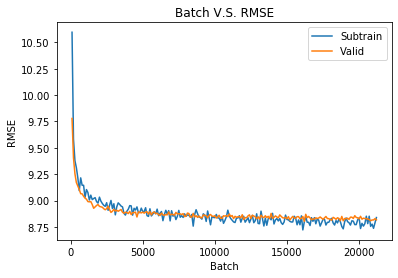

In [22]:
# Q5 Line Chart
plt.plot(batch_list,subtrain_rmse_list,label='Subtrain')
plt.plot(batch_list,valid_rmse_list,label='Valid')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('Batch V.S. RMSE')
plt.legend()
plt.show()

In [23]:
test_accumulated_SSE = 0
test_accumulated_N = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):            
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape((-1, 1))
        outputs = best_net(inputs)        
        cn_loss = loss_fn(outputs, targets) * len(inputs)
        test_accumulated_N += len(inputs)
        test_accumulated_SSE += cn_loss

rmse = math.sqrt(test_accumulated_SSE / test_accumulated_N)
print("TESTING RMSE:", rmse)

TESTING RMSE: 9.04140611498747


Q5解釋：  
有Dropout之後可以看見，subtrain的RMSE有非常密集、像是鋸齒狀的上上下下。  
不過，subtrain和validation的RMSE表現也比較相近，可知overfitting的問題比SGD來的和緩。另外，在有dropout的情況下，需要訓練更多的batch才可以達到early-stopping。最終訓練的Test RMSE表現則約為9.04。

#### Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

In [24]:
H_list=[20, 45, 180, 360]
Outcome_list=[]

for i in range(len(H_list)):
    net=CreateNetwithDropout(H_list[i])
        
    # define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    # Binary Cross Entropy Loss
    loss_fn = torch.nn.MSELoss()

    best_net=training(net,False)
    testing_rmse=testing(best_net)
    temp_outcome=[H_list[i],testing_rmse]
    print(temp_outcome)
    Outcome_list.append(temp_outcome)

Running on device:  cpu
EARLY STOP AT: 14101
TESTING RMSE: 9.405636384029219
[20, 9.405636384029219]
Running on device:  cpu
EARLY STOP AT: 18301
TESTING RMSE: 9.154386675805007
[45, 9.154386675805007]
Running on device:  cpu
EARLY STOP AT: 12001
TESTING RMSE: 8.95589448126052
[180, 8.95589448126052]
Running on device:  cpu
EARLY STOP AT: 24901
TESTING RMSE: 9.010088458542553
[360, 9.010088458542553]


In [25]:
# print(Outcome_list)
df=pd.DataFrame(Outcome_list,columns = ['H','RMSE'])
df

,H,RMSE
0,20,9.405636
1,45,9.154387
2,180,8.955894
3,360,9.010088


Q6解釋：  
各H對應RMSE如上表格所述，表現最佳的是在H=180的情況。
由表格可知，在有使用dropout以及使用Adam更新參數的情況下，H設為180可能會有較好的RMSE表現；反之H設為20時的RMSE表現則明顯差於其他的H值。

#### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


In [26]:
def L2PlusL1Loss(y,yhat,z):
    return z*torch.sum((y-yhat)**2)+(1-z)*torch.sum(torch.abs(y-yhat))

In [27]:
def Q7Train(net,z,showsuboutcome):
    print("Z:",z)
    net=CreateNetwithDropout(90)

    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    mse = torch.nn.MSELoss()

    nepoch = 100 
    step_count = 0 # batch number
    log_interval = 100
    subtrain_accumulated_sse = 0
    subtrain_accumulated_N = 0

    validation_minrmse = 999999
    best_net = copy.deepcopy(net)
    best_step_count = 0
    earlystop_waiting = 0

    for epoch_id in range(0, nepoch):
        early_stop=False
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))
            step_count += 1
            net.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)        
            loss = L2PlusL1Loss(outputs, targets, z)
            sse = mse(outputs, targets) * len(inputs)

            subtrain_accumulated_sse += sse
            subtrain_accumulated_N += len(inputs)

            loss.backward()
            optimizer.step()
            earlystop_waiting+=1
            if step_count % log_interval == 0:
                subtrain_rmse = math.sqrt(subtrain_accumulated_sse / subtrain_accumulated_N)
                subtrain_accumulated_sse = 0
                subtrain_accumulated_N = 0
                valid_rmse = calculate_ValidRMSE(net)
                if showsuboutcome:
                    print("Epoch %d Step %d Subtrain_RMSE = %.3f Validation_RMSE = %.3f" % (epoch_id, step_count, subtrain_rmse, valid_rmse))
                if(valid_rmse<validation_minrmse):
                    validation_minrmse=valid_rmse
                    best_net=copy.deepcopy(net)
                    best_step_count=step_count
                    earlystop_waiting=0
            if earlystop_waiting>5000:
                early_stop=True
                break;
        if(early_stop):
            print("Best Step:", best_step_count)
            print("Early stop at:", step_count)
            break;
    return best_net

In [28]:
net=CreateNetwithDropout(90)

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
mse = torch.nn.MSELoss()

nepoch = 100 
step_count = 0 # batch number
log_interval = 100
subtrain_accumulated_sse = 0
subtrain_accumulated_N = 0

validation_minrmse = 999999
best_net = copy.deepcopy(net)
best_step_count = 0
earlystop_waiting = 0

batch_list=[]
subtrain_rmse_list=[]
valid_rmse_list=[]

z=0.5

for epoch_id in range(0, nepoch):
    early_stop=False
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))
        step_count += 1
        net.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = L2PlusL1Loss(outputs, targets, z)
        sse = mse(outputs, targets) * len(inputs)
        
        subtrain_accumulated_sse += sse
        subtrain_accumulated_N += len(inputs)
        
        loss.backward()
        optimizer.step()
        earlystop_waiting+=1
        if step_count % log_interval == 0:
            subtrain_rmse = math.sqrt(subtrain_accumulated_sse / subtrain_accumulated_N)
            batch_list.append(step_count)
            subtrain_rmse_list.append(subtrain_rmse)
            subtrain_accumulated_sse = 0
            subtrain_accumulated_N = 0
            valid_rmse = calculate_ValidRMSE(net)
            valid_rmse_list.append(valid_rmse)
            print("Epoch %d Step %d Subtrain_RMSE = %.3f Validation_RMSE = %.3f" % (epoch_id, step_count, subtrain_rmse, valid_rmse))
            if(valid_rmse<validation_minrmse):
                validation_minrmse=valid_rmse
                best_net=copy.deepcopy(net)
                best_step_count=step_count
                earlystop_waiting=0
        if earlystop_waiting>5000:
            early_stop=True
            break;
    if(early_stop):
        print("Best Step:", best_step_count)
        print("Early stop at:", step_count)
        break;

Running on device:  cpu
Epoch 0 Step 100 Subtrain_RMSE = 10.576 Validation_RMSE = 9.883
Epoch 0 Step 200 Subtrain_RMSE = 9.635 Validation_RMSE = 9.404
Epoch 0 Step 300 Subtrain_RMSE = 9.370 Validation_RMSE = 9.272
Epoch 0 Step 400 Subtrain_RMSE = 9.311 Validation_RMSE = 9.195
Epoch 1 Step 500 Subtrain_RMSE = 9.219 Validation_RMSE = 9.128
Epoch 1 Step 600 Subtrain_RMSE = 9.209 Validation_RMSE = 9.128
Epoch 1 Step 700 Subtrain_RMSE = 9.161 Validation_RMSE = 9.067
Epoch 1 Step 800 Subtrain_RMSE = 9.143 Validation_RMSE = 9.049
Epoch 2 Step 900 Subtrain_RMSE = 9.066 Validation_RMSE = 9.067
Epoch 2 Step 1000 Subtrain_RMSE = 9.101 Validation_RMSE = 9.016
Epoch 2 Step 1100 Subtrain_RMSE = 9.073 Validation_RMSE = 8.999
Epoch 2 Step 1200 Subtrain_RMSE = 9.093 Validation_RMSE = 8.995
Epoch 3 Step 1300 Subtrain_RMSE = 9.028 Validation_RMSE = 9.001
Epoch 3 Step 1400 Subtrain_RMSE = 9.044 Validation_RMSE = 8.967
Epoch 3 Step 1500 Subtrain_RMSE = 9.040 Validation_RMSE = 8.968
Epoch 3 Step 1600 Subtra

Epoch 30 Step 12800 Subtrain_RMSE = 8.813 Validation_RMSE = 8.829
Epoch 30 Step 12900 Subtrain_RMSE = 8.845 Validation_RMSE = 8.891
Epoch 31 Step 13000 Subtrain_RMSE = 8.840 Validation_RMSE = 8.883
Epoch 31 Step 13100 Subtrain_RMSE = 8.815 Validation_RMSE = 8.849
Epoch 31 Step 13200 Subtrain_RMSE = 8.824 Validation_RMSE = 8.839
Epoch 31 Step 13300 Subtrain_RMSE = 8.816 Validation_RMSE = 8.852
Epoch 32 Step 13400 Subtrain_RMSE = 8.757 Validation_RMSE = 8.877
Epoch 32 Step 13500 Subtrain_RMSE = 8.833 Validation_RMSE = 8.841
Epoch 32 Step 13600 Subtrain_RMSE = 8.827 Validation_RMSE = 8.858
Epoch 32 Step 13700 Subtrain_RMSE = 8.862 Validation_RMSE = 8.854
Epoch 33 Step 13800 Subtrain_RMSE = 8.778 Validation_RMSE = 8.842
Epoch 33 Step 13900 Subtrain_RMSE = 8.762 Validation_RMSE = 8.858
Epoch 33 Step 14000 Subtrain_RMSE = 8.835 Validation_RMSE = 8.841
Epoch 33 Step 14100 Subtrain_RMSE = 8.859 Validation_RMSE = 8.851
Epoch 33 Step 14200 Subtrain_RMSE = 8.806 Validation_RMSE = 8.821
Epoch 34 S

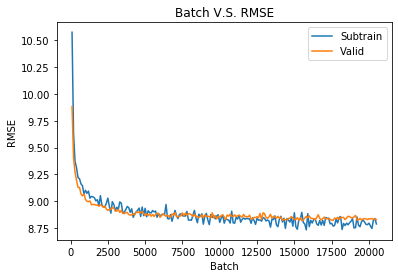

In [29]:
# Q7 Line Chart
plt.plot(batch_list,subtrain_rmse_list,label='Subtrain')
plt.plot(batch_list,valid_rmse_list,label='Valid')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('Batch V.S. RMSE')
plt.legend()
plt.show()

In [30]:
test_accumulated_SSE = 0
test_accumulated_N = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):            
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape((-1, 1))
        outputs = best_net(inputs)        
        cn_loss = mse(outputs, targets) * len(inputs)
        test_accumulated_N += len(inputs)
        test_accumulated_SSE += cn_loss

rmse = math.sqrt(test_accumulated_SSE / test_accumulated_N)
print("TESTING RMSE:", rmse)

TESTING RMSE: 9.022216925700386


In [31]:
z_list=[0.0, 0.1, 0.9, 1.0]
z_tune_outcome_list=[]
z_tune_outcome_list.append([0.5,rmse])

for i in range(len(z_list)):
    
    best_net=Q7Train(net,z_list[i],False)
    
    test_accumulated_SSE = 0
    test_accumulated_N = 0

    # testing
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):            
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = best_net(inputs)        
            cn_loss = mse(outputs, targets) * len(inputs)
            test_accumulated_N += len(inputs)
            test_accumulated_SSE += cn_loss

    rmse = math.sqrt(test_accumulated_SSE / test_accumulated_N)
    print("TESTING RMSE:", rmse)
    z_tune_outcome_list.append([z_list[i],rmse])

Z: 0.0
Running on device:  cpu
Best Step: 6400
Early stop at: 11401
TESTING RMSE: 9.281065454157485
Z: 0.1
Running on device:  cpu
Best Step: 15000
Early stop at: 20001
TESTING RMSE: 9.044107649664003
Z: 0.9
Running on device:  cpu
Best Step: 7400
Early stop at: 12401
TESTING RMSE: 9.018497954697708
Z: 1.0
Running on device:  cpu
Best Step: 18000
Early stop at: 23001
TESTING RMSE: 9.025646121072553


In [32]:
# print(z_tune_outcome_list)
df=pd.DataFrame(z_tune_outcome_list,columns = ['Z','RMSE'])
df

,Z,RMSE
0,0.5,9.022217
1,0.0,9.281065
2,0.1,9.044108
3,0.9,9.018498
4,1.0,9.025646


Q7解釋：  
Training和Validation RMSE的圖如上輸出所示，當z=0.5的時候，可得RMSE約為9.022。  
比較 z = 0.0, 0.1, 0.9, 1.0，可知當z=0.9時有最好的RMSE表現，z=0的時候RMSE表現最差。

#### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


In [33]:
def L2PlusCustomerizedLoss(y,yhat,z):
    return z*torch.sum((y-yhat)**2)+(1-z)*torch.sum(0.5*torch.clamp(y-yhat,min=0)+0.5*torch.clamp(yhat-y,min=0))

In [34]:
def Q8Train(net,z,showsuboutcome):
    
    net=CreateNetwithDropout(90)
    print("Z",z)

    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    mse = torch.nn.MSELoss()

    nepoch = 100 
    step_count = 0 # batch number
    log_interval = 100
    subtrain_accumulated_sse = 0
    subtrain_accumulated_N = 0

    validation_minrmse = 999999
    best_net = copy.deepcopy(net)
    best_step_count = 0
    earlystop_waiting = 0

    for epoch_id in range(0, nepoch):
        early_stop=False
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))
            step_count += 1
            net.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)        
            loss = L2PlusCustomerizedLoss(outputs, targets, z)
            sse = mse(outputs, targets) * len(inputs)

            subtrain_accumulated_sse += sse
            subtrain_accumulated_N += len(inputs)

            loss.backward()
            optimizer.step()
            earlystop_waiting+=1
            
            if step_count % log_interval == 0:
                subtrain_rmse = math.sqrt(subtrain_accumulated_sse / subtrain_accumulated_N)
                batch_list.append(step_count)
                subtrain_rmse_list.append(subtrain_rmse)
                subtrain_accumulated_sse = 0
                subtrain_accumulated_N = 0
                valid_rmse = calculate_ValidRMSE(net)
                valid_rmse_list.append(valid_rmse)
                if showsuboutcome:
                    print("Epoch %d Step %d Subtrain_RMSE = %.3f Validation_RMSE = %.3f" % (epoch_id, step_count, subtrain_rmse, valid_rmse))
                if(valid_rmse<validation_minrmse):
                    validation_minrmse=valid_rmse
                    best_net=copy.deepcopy(net)
                    best_step_count=step_count
                    earlystop_waiting=0
            if earlystop_waiting>5000:
                early_stop=True
                break;
        if(early_stop):
            print("Best Step:", best_step_count)
            print("Early stop at:", step_count)
            break;
            
    return best_net

In [35]:
net=CreateNetwithDropout(90)

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
mse = torch.nn.MSELoss()

nepoch = 100 
step_count = 0 # batch number
log_interval = 100
subtrain_accumulated_sse = 0
subtrain_accumulated_N = 0

validation_minrmse = 999999
best_net = copy.deepcopy(net)
best_step_count = 0
earlystop_waiting = 0

batch_list=[]
subtrain_rmse_list=[]
valid_rmse_list=[]

z=0

for epoch_id in range(0, nepoch):
    early_stop=False
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))
        step_count += 1
        net.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = L2PlusCustomerizedLoss(outputs, targets, z)
        sse = mse(outputs, targets) * len(inputs)
        
        subtrain_accumulated_sse += sse
        subtrain_accumulated_N += len(inputs)
        
        loss.backward()
        optimizer.step()
        earlystop_waiting+=1
        if step_count % log_interval == 0:
            subtrain_rmse = math.sqrt(subtrain_accumulated_sse / subtrain_accumulated_N)
            batch_list.append(step_count)
            subtrain_rmse_list.append(subtrain_rmse)
            subtrain_accumulated_sse = 0
            subtrain_accumulated_N = 0
            valid_rmse = calculate_ValidRMSE(net)
            valid_rmse_list.append(valid_rmse)
            print("Epoch %d Step %d Subtrain_RMSE = %.3f Validation_RMSE = %.3f" % (epoch_id, step_count, subtrain_rmse, valid_rmse))
            if(valid_rmse<validation_minrmse):
                validation_minrmse=valid_rmse
                best_net=copy.deepcopy(net)
                best_step_count=step_count
                earlystop_waiting=0
        if earlystop_waiting>5000:
            early_stop=True
            break;
    if(early_stop):
        print("Best Step:", best_step_count)
        print("Early stop at:", step_count)
        break;

Running on device:  cpu
Epoch 0 Step 100 Subtrain_RMSE = 11.013 Validation_RMSE = 10.690
Epoch 0 Step 200 Subtrain_RMSE = 10.473 Validation_RMSE = 9.978
Epoch 0 Step 300 Subtrain_RMSE = 9.841 Validation_RMSE = 9.759
Epoch 0 Step 400 Subtrain_RMSE = 9.698 Validation_RMSE = 9.596
Epoch 1 Step 500 Subtrain_RMSE = 9.599 Validation_RMSE = 9.505
Epoch 1 Step 600 Subtrain_RMSE = 9.544 Validation_RMSE = 9.498
Epoch 1 Step 700 Subtrain_RMSE = 9.484 Validation_RMSE = 9.476
Epoch 1 Step 800 Subtrain_RMSE = 9.493 Validation_RMSE = 9.446
Epoch 2 Step 900 Subtrain_RMSE = 9.409 Validation_RMSE = 9.381
Epoch 2 Step 1000 Subtrain_RMSE = 9.398 Validation_RMSE = 9.417
Epoch 2 Step 1100 Subtrain_RMSE = 9.465 Validation_RMSE = 9.336
Epoch 2 Step 1200 Subtrain_RMSE = 9.372 Validation_RMSE = 9.350
Epoch 3 Step 1300 Subtrain_RMSE = 9.461 Validation_RMSE = 9.413
Epoch 3 Step 1400 Subtrain_RMSE = 9.431 Validation_RMSE = 9.342
Epoch 3 Step 1500 Subtrain_RMSE = 9.328 Validation_RMSE = 9.363
Epoch 3 Step 1600 Subt

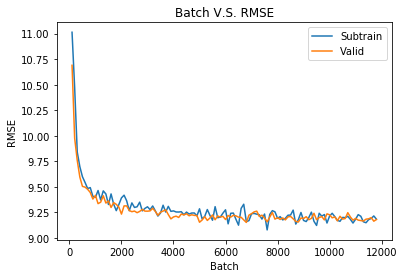

In [36]:
plt.plot(batch_list,subtrain_rmse_list,label='Subtrain')
plt.plot(batch_list,valid_rmse_list,label='Valid')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('Batch V.S. RMSE')
plt.legend()
plt.show()

In [37]:
test_accumulated_SSE = 0
test_accumulated_N = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):            
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape((-1, 1))
        outputs = best_net(inputs)        
        cn_loss = mse(outputs, targets) * len(inputs)
        test_accumulated_N += len(inputs)
        test_accumulated_SSE += cn_loss

rmse = math.sqrt(test_accumulated_SSE / test_accumulated_N)
print("TESTING RMSE:", rmse)

TESTING RMSE: 9.271778347127466


In [38]:
z_list=[0.1, 0.5, 0.9, 1.0]
z_tune_outcome_list=[]
z_tune_outcome_list.append([0.0,rmse])

for i in range(len(z_list)):
    
    best_net=Q8Train(net,z_list[i],False)
    
    test_accumulated_SSE = 0
    test_accumulated_N = 0

    # testing
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):            
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = best_net(inputs)        
            cn_loss = mse(outputs, targets) * len(inputs)
            test_accumulated_N += len(inputs)
            test_accumulated_SSE += cn_loss

    rmse = math.sqrt(test_accumulated_SSE / test_accumulated_N)
    print("TESTING RMSE:", rmse)
    z_tune_outcome_list.append([z_list[i],rmse])

Running on device:  cpu
Z 0.1
Best Step: 15600
Early stop at: 20601
TESTING RMSE: 9.030499384221116
Running on device:  cpu
Z 0.5
Best Step: 9700
Early stop at: 14701
TESTING RMSE: 9.030550497348223
Running on device:  cpu
Z 0.9
Best Step: 16600
Early stop at: 21601
TESTING RMSE: 9.02092725838504
Running on device:  cpu
Z 1.0
Best Step: 12500
Early stop at: 17501
TESTING RMSE: 9.025626256459386


In [39]:
# print(z_tune_outcome_list)
df=pd.DataFrame(z_tune_outcome_list,columns = ['Z','RMSE'])
df

,Z,RMSE
0,0.0,9.271778
1,0.1,9.030499
2,0.5,9.030550
3,0.9,9.020927
4,1.0,9.025626


Q8解釋：  
Training和Validation RMSE的圖如上輸出所示，當z=0的時候，可得RMSE約為9.272。  
比較 z = 0.1, 0.5, 0.9, 1.0，每個z值的表現都比z=0的時候還要來得好。另外，由表可知當z=0.9時有最好的RMSE表現，z=0.5的時候RMSE表現最差。